In [1]:
pip install sortedcontainers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from sortedcontainers import SortedDict

In [3]:
board = np.zeros((3, 3), dtype=np.int8)

In [4]:
board[0][0] = 1
board[0][1] = 2
board

array([[1, 2, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int8)

In [5]:
np.rot90(board)

array([[0, 0, 0],
       [2, 0, 0],
       [1, 0, 0]], dtype=int8)

In [6]:
np.transpose(board)

array([[1, 0, 0],
       [2, 0, 0],
       [0, 0, 0]], dtype=int8)

In [7]:
def hash(board):
    return ''.join(map(str, board.ravel()))

In [8]:
def get_canonical(board):
    rot1 = np.rot90(board)
    rot2 = np.rot90(rot1)
    rot3 = np.rot90(rot2)
    flip = np.transpose(board)
    flip_rot1 = np.rot90(flip)
    flip_rot2 = np.rot90(flip_rot1)
    flip_rot3 = np.rot90(flip_rot2)

    best = max([
        (hash(rot1), rot1, 1),
        (hash(rot2), rot2, 2),
        (hash(rot3), rot3, 3),
        (hash(flip), flip, 4),
        (hash(flip_rot1), flip_rot1, 5),
        (hash(flip_rot2), flip_rot2, 6),
        (hash(flip_rot3), flip_rot3, 7)
    ], key=lambda x: x[0])

    board_hash = hash(board)
    
    if best[0] > board_hash:
        return best
    else:
        return board_hash, board, 0

In [9]:
get_canonical(board)

('120000000',
 array([[1, 2, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int8),
 0)

In [10]:
def is_win(board, last_played):
    y, x = last_played
    if board[y, 0] == board[y, 1] == board[y, 2] != 0:
        return True
    if board[0, x] == board[1, x] == board[2, x] != 0:
        return True
    if y == x and board[0, 0] == board[1, 1] == board[2, 2]:
        return True
    if y + x == 2 and board[0, 2] == board[1, 1] == board[2, 0]:
        return True

In [11]:
def is_draw(board):
    draw_board = board == 4
    return (
        np.all(np.sum(draw_board, axis=0) != 0) and
        np.all(np.sum(draw_board, axis=1) != 0) and
        np.sum(draw_board.diagonal()) != 0 and
        np.sum(np.fliplr(draw_board).diagonal()) != 0
    )

In [12]:
board[1,0] = 4
board[0,1] = 4
board[2,1] = 4
board[1,2] = 4
board

array([[1, 4, 0],
       [4, 0, 4],
       [0, 4, 0]], dtype=int8)

In [13]:
is_draw(board)

False

In [14]:
board[1,1] = 4
board

array([[1, 4, 0],
       [4, 4, 4],
       [0, 4, 0]], dtype=int8)

In [15]:
is_draw(board)

True

In [16]:
board = np.zeros((3, 3), dtype=np.int8)
by_depth = [SortedDict.fromkeys([hash(board)], (board, [0], []))]

for depth in range(board.size):
    start_positions = by_depth[-1]
    #print('---')
    #print(start_positions)
    by_depth.append(SortedDict())
    valid_positions = by_depth[-1]

    for player in [1, 2, 4]:
        for i, (start_pos_hash, (start_pos, winning_state, _)) in enumerate(start_positions.items()):
            if winning_state[0] > 0:
                continue
            for playable_index in zip(*np.where(start_pos == 0)):
                new_board = start_pos.copy()
                new_board[playable_index] = player
                canonical_hash, canonical_board, _ = get_canonical(new_board)

                if canonical_hash not in valid_positions:
                    if player == 4:
                        winning = player if is_draw(new_board) else 0
                    else:
                        winning = player if is_win(new_board, playable_index) else 0
                    valid_positions.setdefault(canonical_hash, default=(canonical_board, [winning], [i]))
                else:
                    reachable_from = valid_positions[canonical_hash][2]
                    if not reachable_from or reachable_from[-1] != i:
                        reachable_from.append(i)

    print(len(valid_positions))

by_len = list(map(len, by_depth))
by_len

9
60
342
1419
4095
8032
10288
7575
2674


[1, 9, 60, 342, 1419, 4095, 8032, 10288, 7575, 2674]

In [17]:
sum(by_len)

34495

In [18]:
#by_depth[0]

In [19]:
#by_depth[1]

In [20]:
#by_depth[2]

/home/jon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


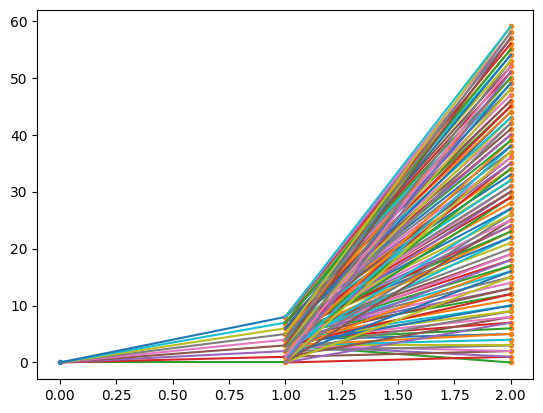

In [21]:
import matplotlib.pyplot as plt

for i, d in enumerate(by_depth[:3]):
    plt.plot([i]*len(d), range(len(d)), '.')
    #print(f'depth {i=}, {len(d)=}')

    for j, e in enumerate(d.values()):
        #print(f'{j=}, {e=}')
        for y in e[2]:
            #print(i, j, int(y))
            plt.plot((i-1,i), (y, j))
plt.show()

In [22]:
# backpropagate winning status

# set all in last row to be draws if they have 0 set as winning
c = 0
for _, winning_state, _ in by_depth[-1].values():
    if winning_state[0] == 0:
        c += 1
        winning_state[0] = 4
c

1129

In [23]:
# [1, 2, 3, 4, 5] -> (4,5), (3,4), (2,3), (1,2)
def pairwise_reversed(it):
    return reversed(list(zip(it[:-1], it[1:])))

for a, b in pairwise_reversed(by_depth):
    va = a.values()
    vb = b.values()

    c = 0
    for _, winning_state, from_index in vb:
        for i in from_index:
            c += 1
            va[i][1][0] |= winning_state[0]
    print(c)

13311
42885
58290
42660
18966
5292
936
108
9


In [24]:
for i, (board, winning_state, _) in enumerate(by_depth[3].values()):
    if winning_state[0] != 7:
        print(i, winning_state[0])
        print(board)

0 1
[[0 1 0]
 [0 1 0]
 [0 1 0]]
10 2
[[0 2 0]
 [0 2 0]
 [0 2 0]]
60 1
[[1 0 0]
 [0 1 0]
 [0 0 1]]
68 5
[[1 0 0]
 [0 4 0]
 [0 0 1]]
91 1
[[1 1 1]
 [0 0 0]
 [0 0 0]]
136 2
[[2 0 0]
 [0 2 0]
 [0 0 2]]
141 6
[[2 0 0]
 [0 4 0]
 [0 0 2]]
197 2
[[2 2 2]
 [0 0 0]
 [0 0 0]]
228 5
[[4 0 0]
 [0 1 0]
 [0 0 1]]
230 5
[[4 0 0]
 [0 1 0]
 [0 0 4]]
235 6
[[4 0 0]
 [0 2 0]
 [0 0 2]]
236 6
[[4 0 0]
 [0 2 0]
 [0 0 4]]
240 5
[[4 0 0]
 [0 4 0]
 [0 0 1]]
241 6
[[4 0 0]
 [0 4 0]
 [0 0 2]]
242 4
[[4 0 0]
 [0 4 0]
 [0 0 4]]


In [25]:
for d in by_depth:
    c = 0
    for i, (board, winning_state, _) in enumerate(d.values()):
        if winning_state[0] != 7:
            c += 1
    print(c)

0
0
0
15
191
1469
4991
8764
7267
2674


In [26]:
import json

all_winstates = SortedDict()
for i in range(len(by_depth)):
    for key in by_depth[i]:
        #print(key)
        #print(winstates[key])
        all_winstates[key] = by_depth[i][key][1][0]

with open('../macro_winstates.json', 'w') as f:
    json.dump(all_winstates, f, ensure_ascii=False, indent=2)